In [75]:
from tensorflow.keras.layers import MaxPooling2D,Flatten, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import seaborn as sns

In [76]:
def claheAdapter(img):
    lab_img= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_img)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(l)
    updated_lab_img2 = cv2.merge((clahe_img,a,b))
    CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2RGB)
    return CLAHE_img

In [77]:
CATEGORIES = ["Glaucoma","Normal","Others"]
TESTDIR =  "C:/Users/User/DL/dataset2/test/"   
TRAINDIR =  "C:/Users/User/DL/dataset2/train/"
VALDIR = "C:/Users/User/DL/dataset2/validation/"
test_images,test_labels, train_images, train_labels,val_images,val_labels= [],[],[],[],[],[]
for category in CATEGORIES:
    path = os.path.join(VALDIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = claheAdapter(cv2.imread(os.path.join(path,img))[:,:,::-1])
        cv2.resize(img_array,(100,100))
        val_images.append(img_array)
        val_labels.append(class_num)
        
for category in CATEGORIES:
    path = os.path.join(TESTDIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = claheAdapter(cv2.imread(os.path.join(path,img))[:,:,::-1])
        cv2.resize(img_array,(100,100))
        test_images.append(img_array)
        test_labels.append(class_num)
        
for category in CATEGORIES:
    path = os.path.join(TRAINDIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = claheAdapter(cv2.imread(os.path.join(path,img))[:,:,::-1])
        cv2.resize(img_array,(100,100))
        train_images.append(img_array)
        train_labels.append(class_num)

In [78]:
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
val_images = np.asarray(val_images)
val_labels = np.asarray(val_labels)
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

In [92]:
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(100,100,3))
model = tf.keras.Sequential()  
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(500,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3,activation='softmax'))
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [93]:
history = model.fit(
      train_images,
      train_labels,
      validation_data=(val_images,val_labels),
      epochs=20
    )

Epoch 1/20
33/33 [==============================] - 24s 611ms/step - loss: 1.3208 - accuracy: 0.4886 - val_loss: 1.1668 - val_accuracy: 0.3315
Epoch 2/20
33/33 [==============================] - 20s 609ms/step - loss: 1.0224 - accuracy: 0.5532 - val_loss: 1.0836 - val_accuracy: 0.3859
Epoch 3/20
33/33 [==============================] - 21s 628ms/step - loss: 0.9847 - accuracy: 0.5856 - val_loss: 1.1254 - val_accuracy: 0.3641
Epoch 4/20
33/33 [==============================] - 21s 630ms/step - loss: 0.9161 - accuracy: 0.5960 - val_loss: 1.0888 - val_accuracy: 0.3098
Epoch 5/20
33/33 [==============================] - 21s 634ms/step - loss: 0.8689 - accuracy: 0.6264 - val_loss: 1.3068 - val_accuracy: 0.3750
Epoch 6/20
33/33 [==============================] - 21s 644ms/step - loss: 0.8320 - accuracy: 0.6321 - val_loss: 1.9950 - val_accuracy: 0.3315
Epoch 7/20
33/33 [==============================] - 19s 571ms/step - loss: 0.8180 - accuracy: 0.6464 - val_loss: 1.4201 - val_accuracy: 0.3315

In [94]:
test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10/10 - 4s - loss: 10.5817 - accuracy: 0.4740

Test accuracy: 0.4740259647369385


In [96]:
checkpoint_path = 'model\CheckpointResNet50'
model.save_weights(checkpoint_path)
model.save('model\ResNet50_model.h5')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 500)               1024500   
_________________________________________________________________
batch_normalization_14 (Batc (None, 500)               2000      
_________________________________________________________________
dropout_13 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 500)             

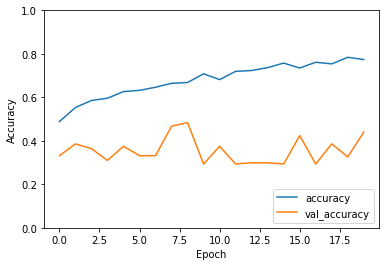

In [103]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.savefig('acc_graph_ResNet50.jpg')

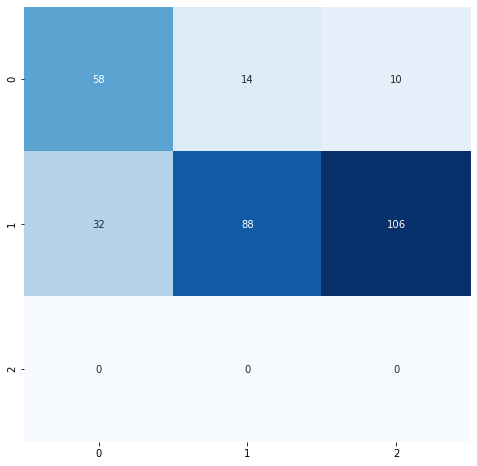

In [105]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

predictions = probability_model.predict(test_images)

PreLabel = []
for i in range(0,len(predictions)):
    PreLabel.append(np.argmax(predictions[i]))
    
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(PreLabel, test_labels), annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)
plt.savefig('confusion_ResNet50.jpg')